In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as md
import pandas as pd
import csv
import datetime
import time
import os
from PyPDF2 import PdfReader, PdfWriter, PdfMerger

#opens the CSV file and stores them as a list of lists
with open(r"C:\Users\sanch\OneDrive\Desktop\JHU REU\cryostat_data.csv",) as csvfile:
    fridgedata=csv.reader(csvfile)
    fridgedata_list = list(fridgedata)
    

#To find the correct column:


#Contents of Code by Functions:
#1 get_run_indices
#2 get_unixtime_array -now gives datetime object array since cannot use unix time
#3 get_string_date_array
#4 get_daysinterval_array - commented out since cannot use unix time
#5 replace_strings
#5.5 replace_yn_strings
#6 get_fridge_temp(Ci,runname)
#7 find_cooldown_date
#8 get_graph_temp(Ci, runname)
#9 get_fridge_pressure(Pi,runname)
#10 get_graph_pressure(Pi, runname)
#11 def plot_turbo_status(runname)


print(fridgedata_list[0][12])


Is the magnet on?


In [2]:
#gettting the correct indices to the different runs that can be called

#these are the runs with availble data to graph
#Test runs are not the same as runs and there will be both 'test run' and 'run' of the same number
    
run1='run1'
run2='run2'
run3='run3'
run4='run4'
test_run5='test run5'
test_run6='test run6'
test_run7='test run7'
 
    
    #this gives the program the row indices to acess the data for each run
    #the indices must be updates everytime the CSV has rows added or subtracted
    
def get_run_indices(runname):
        
    run_index_array=[]
        
    if runname=='run1':
        run_index_array=[46,64]
            
    if runname=='run2':
        run_index_array=[66,79]
            
    if runname=='run3':
        run_index_array=[81,129]
            
    if runname=='run4':
        run_index_array=[2,5]
            
    if runname=='test run5':
        run_index_array=[7,26]
            
    if runname=='test run6':
        run_index_array=[28,44]
    
    if runname=='test run7':
        run_index_array=[131,136]
            
    return run_index_array
    


In [3]:
#gets the unix date in an array

def get_unixtime_array(runname):
    
        #declare the row indices for the run
        run_index=get_run_indices(runname)
        runstart=run_index[0]
        runend=run_index[1]
       
        #create array to export the data
        unix_timestamp=[]
        
        #trying to export as datetime object instead of unix integer
        timestamp_array=[]
          
        for index in range (runstart,runend):
            date_run1=fridgedata_list[index][1]
            time_run1=fridgedata_list[index][5]
            
            
            month, day, year = date_run1.split("/")
            hour, minute =time_run1.split(":")
        
            
            timestamp = datetime.datetime(int(year), int(month), int(day), int(hour), int(minute))
            
            #unix_timestamp.append(time.mktime(timestamp.timetuple()))
            timestamp_array.append(timestamp)
           
          
        return timestamp_array
    

print(get_unixtime_array(run2))

[datetime.datetime(2022, 12, 15, 7, 50), datetime.datetime(2022, 12, 15, 17, 40), datetime.datetime(2022, 12, 16, 9, 11), datetime.datetime(2022, 12, 16, 17, 11), datetime.datetime(2022, 12, 17, 11, 17), datetime.datetime(2022, 12, 18, 11, 35), datetime.datetime(2022, 12, 19, 8, 30), datetime.datetime(2022, 12, 19, 17, 30), datetime.datetime(2022, 12, 20, 8, 30), datetime.datetime(2022, 12, 20, 17, 0), datetime.datetime(2022, 12, 21, 8, 8), datetime.datetime(2022, 12, 22, 8, 20), datetime.datetime(2022, 12, 22, 17, 30)]


In [4]:
#gets the mm/dd/yyyy date string in an array

def get_string_date_array(runname):
    
    #declare the row indices for the run
    
    run_index=get_run_indices(runname)
    runstart=run_index[0]
    runend=run_index[1]
    
    string_date_array=[]
        
    for index in range (runstart, runend):
        date=fridgedata_list[index][1]
        string_date_array.append(date)  
            
          
    return string_date_array
    
    
    
    
    


print(get_string_date_array(test_run7))



['1/31/2023', '2/1/2023', '2/1/2023', '2/3/2023', '2/6/2023']


In [5]:
#creates an array to label the days on the graph

#def get_daysinterval_array(runname):


    #first_day=get_unixtime_array(runname)[0]
    #last_day=get_unixtime_array(runname)[-1]
    

    #num_days=(last_day-first_day)/86400
    #num_days= int(num_days)
    
    #num_days=num_days+1
    #last_day=last_day+86400
    
    #day_label=[first_day]

   

    #for i in range(1,num_days):
  
        #day_label.append(day_label[i-1]+86400)
    
        #if day_label[i]>last_day:
            #break
    
    #return day_label




In [6]:
#replaces the string values: "NA", "unseen", etc. where we did not record info or could not read the paramter 

#different paramter groups have different ranges so we need different values:
#for Ci we use 1e-2 since it falls below our range of temperature to the order of 1e0 and we are using a log scale
#for Pi we use 1e3 since this is above our range of pressure in mK and we are using a log scale
#for the other values we are plotting temp in normal room pressure or percentages (all >0) so -1 is fine
#for the heat valve, we plot -1 for no values written, unless the entry is "yes", then we plot 110
    
Ci_string="Ci" 
Pi_string="Pi"
other_string="other" 
heat_valve = "heat"

def replace_strings(array_in, value):
    
    array_end = len(array_in)
    
    for index in range (0,array_end):
            
        try:
            array_in[index]=float(array_in[index])
            
        except ValueError:
            if value=="Ci":
                array_in[index]= 1e-2     
            if value == "Pi":
                array_in[index]= 1e3
            if value== "other":
                array_in[index] = -1
            if value == "heat":
                if array_in[index]== "Yes":
                    array_in[index]=110
                else:
                    array_in[index]= -1
        
        #I added this to change replacing -1 to new values since logscale doesn't like the -1 and CSV file was edited prior
        if array_in[index]== -1.0:
            if value == "Ci":
                array_in[index] = 1e-2
            if value == "Pi":
                array_in[index] = 1e3
            
    return array_in
        
#For testing    
practice_array1=['0.9', '0.9', '0.5', 'NA', '1.4', '0.5', '2', 'null', '3', '4','-1', 'off', '5.9'] 
print(replace_strings(practice_array1, other_string))   
     
    

[0.9, 0.9, 0.5, -1, 1.4, 0.5, 2.0, -1, 3.0, 4.0, -1.0, -1, 5.9]


In [7]:
def replace_yn_strings(array_in):
    array_end = len(array_in)
    
    for index in range (0,array_end):
            
        if array_in[index] != "Yes" and array_in[index] != "No":
            
            array_in[index]= "non data"
            
    return array_in

array_yn =["Yes", "No", "null", "Yes", "no", "null"]
replace_yn_strings(array_yn)

['Yes', 'No', 'non data', 'Yes', 'non data', 'non data']

In [8]:
#getting the data from the fridge temperatures

C1="C1"
C2="C2"
C3="C3"
C4="C4"
C5="C5"
C6="C6"

def get_fridge_temp(Ci,runname):
    run_index=get_run_indices(runname)
    runstart=run_index[0]
    runend=run_index[1]
    
    C1_array=[]
    C2_array=[]
    C3_array=[]
    C4_array=[]
    C5_array=[]
    C6_array=[]
    
   
    
    if Ci == "C1":
        for index in range (runstart,runend):
        
            C1_array.append(fridgedata_list[index][6])
              
        C1_array=replace_strings(C1_array, Ci_string)
            
        return C1_array
        
    if Ci == "C2":
        for index in range (runstart,runend):
        
           C2_array.append(fridgedata_list[index][7])
              
        C2_array=replace_strings(C2_array, Ci_string)
            
        return C2_array
    
    if Ci == "C3":
        for index in range (runstart,runend):
        
            C3_array.append(fridgedata_list[index][8])
            
        C3_array = replace_strings(C3_array, Ci_string)    
            
        return C3_array
    
    if Ci == "C4":
        for index in range (runstart,runend):
        
            C4_array.append(fridgedata_list[index][9])
            
        #EDIT:add this print to see if removing strings
        print(C4_array)
        
        #EDIT changing Ci--> to Pi
        C4_array = replace_strings(C4_array, Ci_string)
        print(C4_array)
            
        return C4_array
    
    if Ci == "C5":
        for index in range (runstart,runend):
        
            C5_array.append(fridgedata_list[index][10])
            
        C5_array = replace_strings(C5_array, Ci_string)
            
        return C5_array
    
    if Ci == "C6":
        for index in range (runstart,runend):
        
            C6_array.append(fridgedata_list[index][11])
              
        C6_array = replace_strings(C6_array, Ci_string)
            
        return C6_array
    
    
 
    



get_fridge_temp(C3,test_run7)


[0.01, 0.01, 0.01, 0.01, 0.01]

In [9]:
#finds the date in unixtime (now datetime object) that the temperature is below 4e3 mK or is in the order of 1*e1 mK 
def find_cooldown_date(Ci, runname):
    temp_array=get_fridge_temp(Ci,runname)

    
    for index in range(0,len(temp_array)):
        if temp_array[index] <= 4e3 and temp_array[index] != 1e-2:
            data_day=index
            break
   
    unixtime_array=get_unixtime_array(runname)
    day_cooldown= unixtime_array[data_day]
    
   
    
    return day_cooldown
    
def find_cooldown_index(Ci, runname):
    temp_array = get_fridge_temp(Ci,runname)

  
    for index in range(0,len(temp_array)):
        if temp_array[index] <= 4e3 and temp_array[index] != 1e-2:
            data_day=index
            break
            
    return data_day



[293000.0, 293000.0, 294000.0, 294000.0, 294000.0]


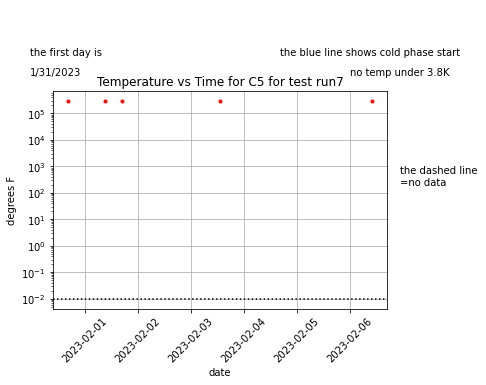

In [10]:
#graphs the temperatures for each valve and run
def get_graph_temp(Ci, runname):
    
    #EDIT why is this not plotting the 1e-3 for c3, run1
    print(get_fridge_temp(Ci,runname))
    
    plt.figure()
    if Ci =="C6":
        plt.title("Resistance vs Time for "+ Ci +" for " + runname,)
        plt.ylabel("R in kOhm")
    else:
        plt.title("Temperature vs Time for " + Ci + " for " + runname)
        plt.ylabel("degrees F")
        
    plt.xlabel("date")
    plt.yscale("log")
    plt.plot(get_unixtime_array(runname),get_fridge_temp(Ci,runname) , 'r.') 
    plt.xticks(rotation=45)
    
    #plots date labels
    plt.annotate( "the first day is", (30,330), xycoords='figure pixels')
    plt.annotate( get_string_date_array(runname)[0], (30,310), xycoords='figure pixels')
    plt.annotate( "the blue line shows cold phase start", (280,330), xycoords='figure pixels')
    
    
    #plots lies to show the progession of days - can only use when graphing unix time
    #day_for_grid = get_daysinterval_array(runname)
    
    #for i in range(len(day_for_grid)):
        #plt.axvline(day_for_grid[i], ls='--', linewidth=.75,color='0')
        
    #plots the day when the run enters cooldown phase
    plt.grid()
    try:
        cooldown_day=find_cooldown_date(Ci, runname)    
        plt.axvline(cooldown_day,linewidth=.75,color='b')
    
        cooldown_index=find_cooldown_index(Ci, runname)
        plt.annotate( get_string_date_array(runname)[cooldown_index], (350,310), xycoords='figure pixels')
        
    except UnboundLocalError:
        plt.annotate("no temp under 3.8K", (350,310), xycoords='figure pixels')
    
    #plot the line for non-data values that were recorded
    plt.axhline(1e-2, linestyle = "dotted", color ="0")
    dashed_line_txt= "the dashed line \n=no data"
    plt.annotate(dashed_line_txt, (400,200), xycoords='figure pixels')   
    
    #saves the plots to a a different folder than working directory
    my_path = os.path.abspath(r"C:\Users\sanch\OneDrive\Desktop\JHU REU\crostat_plots\temperature_plots")
    my_file = Ci + " "+ runname
    plt.savefig(os.path.join(my_path, my_file),  pad_inches=0.3, facecolor='w', format = "pdf" )   
        
    plt.show()
    
    #print(cooldown_day)
    
get_graph_temp(C5,test_run7)


In [11]:
#getting the data from the fridge temperatures

P1="P1"
P2="P2"
P3="P3"
P4="P4"
P5="P5"
P6="P6"

def get_fridge_pressure(Pi,runname):
    
    #Get the indices for the run
    run_index=get_run_indices(runname)
    runstart=run_index[0]
    runend=run_index[1]
    
    #declare the arrays for different pressures    
    P1_array=[]
    P2_array=[]
    P3_array=[]
    P4_array=[]
    P5_array=[]
    P6_array=[]
    
    #Get the correct column for the array
    if Pi == "P1":
        for index in range (runstart,runend):
        
            P1_array.append(fridgedata_list[index][22])
            
        P1_array =replace_strings(P1_array,Pi_string)
            
        return P1_array
        
    if Pi == "P2":
        for index in range (runstart,runend):
        
           P2_array.append(fridgedata_list[index][23])
            
        P2_array = replace_strings(P2_array, Pi_string)
        
        return P2_array
    
    if Pi == "P3":
        for index in range (runstart,runend):
        
            P3_array.append(fridgedata_list[index][24])
            
        P3_array = replace_strings(P3_array, Pi_string)
            
        return P3_array
    
    if Pi == "P4":
        for index in range (runstart,runend):
        
            P4_array.append(fridgedata_list[index][25])
            
        P4_array = replace_strings(P4_array, Pi_string)
            
        return P4_array
    
    if Pi == "P5":
        for index in range (runstart,runend):
        
            P5_array.append(fridgedata_list[index][26])
            
        P5_array = replace_strings(P5_array, Pi_string)
            
        return P5_array
    
    if Pi == "P6":
        for index in range (runstart,runend):
        
            P6_array.append(fridgedata_list[index][27])
            
        P6_array = replace_strings(P6_array, Pi_string)
            
        return P6_array
    
       

P_array=get_fridge_pressure(P2,run3)  

print(P_array)


[0.00161, 0.00091, 0.00089, 0.000879, 0.000878, 0.00518, 8.35, 0.0187, 0.0183, 0.0186, 0.0183, 0.0184, 0.0185, 0.0185, 0.0185, 0.0184, 0.0183, 0.0182, 0.0181, 0.0183, 0.0182, 0.0182, 0.0181, 0.0182, 0.0181, 0.018, 0.0181, 0.0181, 0.0181, 0.0183, 0.018, 0.0181, 0.0185, 0.0181, 0.018, 0.0184, 0.0183, 0.0183, 0.0183, 0.0183, 0.0183, 0.0184, 0.0183, 0.00539, 0.012, 0.0149, 0.0206, 0.0235]


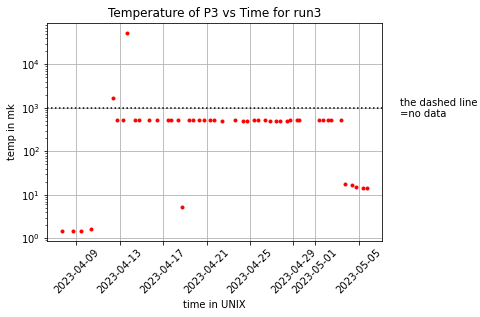

In [12]:
#graph the pressures for each valve and run

def get_graph_pressure(Pi, runname):
    plt.figure()
    plt.title("Temperature of " + Pi +" vs Time for " + runname,)
    plt.xlabel("time in UNIX")
    plt.ylabel("temp in mk")
    plt.yscale("log")
    plt.plot(get_unixtime_array(runname),get_fridge_pressure(Pi,runname) , 'r.') 
    plt.xticks(rotation=45)
    
    
    #plots lines to show progression of days 
    #day_for_grid = get_daysinterval_array(runname)
    
    #for i in range(len(day_for_grid)):
          #plt.axvline(day_for_grid[i], ls='--', linewidth=.75,color='0')
        
    #plot the line for non-data values that were recorded
    plt.axhline(1e3, linestyle = "dotted", color ="0")
    dashed_line_txt= "the dashed line \n=no data"
    plt.annotate(dashed_line_txt, (400,200), xycoords='figure pixels')   
    
    
    #saves the plots to a a different folder than working directory
    my_path = os.path.abspath(r"C:\Users\sanch\OneDrive\Desktop\JHU REU\crostat_plots\pressure_plots")
    my_file = Pi + " "+ runname
    plt.savefig(os.path.join(my_path, my_file),  pad_inches=0.3, facecolor='w', format = "pdf" )   
            
    
    plt.grid()
    plt.show()


get_graph_pressure(P3,run3)





this is the graph for:


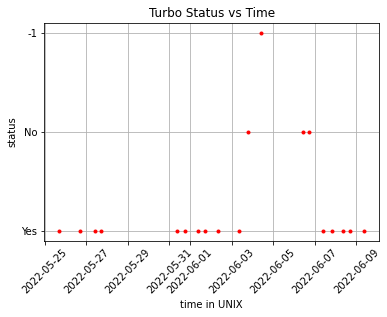

In [13]:
def plot_turbo_status(runname):
    #get run indices
    run_index=get_run_indices(runname)
    runstart=run_index[0]
    runend=run_index[1]
    
    #get turbo data
    turbo_status=[]
    for index in range (runstart,runend):
        turbo_status.append(fridgedata_list[index][29])
    
        
      
    #graphs the status
    plt.figure()
    plt.title("Turbo Status vs Time")
    plt.xlabel("time in UNIX")
    plt.ylabel("status")
    plt.plot(get_unixtime_array(runname),turbo_status, 'r.') 
    plt.xticks(rotation=45)
    print('this is the graph for:')
    

    
    #only works for unix time
    #day_for_grid = get_daysinterval_array(runname)
    
    #for i in range(len(day_for_grid)):
        #plt.axvline(day_for_grid[i],ls ="--", linewidth=.75,color='0')
    plt.grid()
    plt.show()
    
    return

plot_turbo_status(test_run5)

#get_axisday_array(test_run5)

In [14]:
#Define the keys for calling different plots and their cooresponding info

#These are your options to graph:
water_supply_temp = "water supply temperature"
inlet_temp = "inlet temperature"
outlet_temp = "outlet temperature"
supply_pressure = "suppy pressure"
domestic_water_pressure = "domestic water pressure"
water_return_pressure = "water return pressure"
water_flow_rate = "water flow rate"
water_pressure_1A = "water pressure after pump 1A"
water_pressure_1B = "water Pressure after pump 1B"
humidity_percentage = "humidity percentage"

#these are other options to graph that are yes/no in possible output
magnet_on="if magnet is on"
water_treatment="if is water being treated"
chemical_tank_valves="if the chemical tank valves are closed"
bypass_mode="if in bypass mode"
water_loop_pumps="if water loop pumps are on"
is_1A_running="if 1A is running"
is_1B_running="if 1B is running"
nitrogen_coldtrap="if there is liquid Nitrogen in the cold trap"
O2_sensor="is the O2 sensor in range"
heat_exchange_valve="what percent is the heat exchange valve open" 
DR_control="is the DR control on"

#declares the column in the CSV file to access and returns an array of the info called 'paramter_info' needed to plot
def get_parameter_info(parameter):

#the info is acessed by the index as follows:
#paramter_info[0] = column_index
#paramter_info[1] = yunits

    #define the values to input:
    
    #these paramters have a 'typeoutput' that are called by value_output
    if parameter == "water supply temperature":
        column_index = 40
        yunits = "degrees F "
        typeoutput = "other"
        
        
    if parameter == "inlet temperature":
        column_index = 41
        yunits = "degrees F"
        typeoutput = "other"
        
    if parameter ==  "outlet temperature":
        column_index = 42
        yunits = "degrees F"
        typeoutput = "other"
        
    if parameter == "suppy pressure":
        column_index = 43
        yunits = "psig"
        typeoutput = "other"
    
    if parameter == "domestic water pressure":
        column_index = 44
        yunits = "psi"
        typeoutput = "other"
        
    if parameter == "water return pressure":
        column_index = 45
        yunits = "psig"
        typeoutput = "other"
    
    if parameter == "water flow rate":
        column_index = 46
        yunits = "gallons per minute"
        typeoutput = "other"
        
    if parameter == "water pressure after pump 1A":
        column_index = 47
        yunits = "psi"
        typeoutput = "other"
        
    if parameter == "water Pressure after pump 1B":
        column_index = 48
        yunits = "psi"
        typeoutput = "other"
        
    if parameter == "humidity percentage":
        column_index = 64
        yunits = "% humidity in lab"
        typeoutput = "other"
        
    #These outputs are YN type
        
    if parameter == "if magnet is on":
        column_index = 12
        yunits = "status" 
        typeoutput = "YN"
        
    if parameter == "if is water being treated":
        column_index = 49
        yunits = "status" 
        typeoutput = "YN"
    
    if parameter == "if the chemical tank valves are closed":
        column_index = 50
        yunits = "status"    
        typeoutput = "YN"
        
    if parameter == "if in bypass mode":
        column_index = 51
        yunits = "status" 
        typeoutput = "YN"
    
    if parameter == "if water loop pumps are on":
        column_index = 52
        yunits = "status" 
        typeoutput = "YN"
        
    if parameter == "if 1A is running" :
        column_index = 53
        yunits = "status" 
        typeoutput = "YN"
    
    if parameter =="if 1B is running"  :
        column_index = 54
        yunits = "status"
        typeoutput = "YN"
    
    if parameter =="if there is liquid Nitrogen in the cold trap" :
        column_index = 55
        yunits = "status"
        typeoutput = "YN"
        
    if parameter == "is the O2 sensor in range":
        column_index = 56
        yunits = "status"
        typeoutput = "YN"
        
    if parameter =="what percent is the heat exchange valve open":
        column_index = 57
        yunits = "status"
        typeoutput = "heat"
        
    if parameter =="is the DR control on":
        column_index = 58
        yunits = "status"
        typeoutput = "YN"
       
    parameter_info = [column_index, yunits, typeoutput]
    
    return parameter_info
    
    
get_parameter_info(magnet_on)



[12, 'status', 'YN']

In [15]:
#this now gets the parameter data in an array based on the run and then cleans the data by replacing strings with "-1"

#define what type of output the data is
#value_output= "value"
#YN_output = "yes_or_no"
#heat_open ="heat open"


def get_parameter_array(parameter,runname):
        
    #calls the row indices for the run
    run_index=get_run_indices(runname)
    runstart=run_index[0]
    runend=run_index[1]
    
    #calls the column index to acess the CSV data
    column_index = get_parameter_info(parameter)[0]
    
    #creates the parameter array by acessing CSV file
    parameter_array=[]
    
    for index in range (runstart,runend):
        parameter_array.append(fridgedata_list[index][column_index])
        
    #this tells us how to replace strinf with correct values
    type_output = get_parameter_info(parameter)[2]
    
    if type_output == "other":
        parameter_array = replace_strings(parameter_array, type_output )
        
    elif type_output =="heat":
        parameter_array = replace_strings(parameter_array, type_output )
        
    else:
        paramter_array = replace_yn_strings(parameter_array)

    
    #this converts the percentages from decimal form becuase I couldn't figure it out in excel. don't convert '-1' values
    #it works if you round it to 3 Sig Figs
    
    if parameter=="humidity percentage":
        for i in range(len(parameter_array)):
            if parameter_array[i] != -1:
                parameter_array[i] = 100*parameter_array[i]
    
    
    return parameter_array

test1 = get_parameter_array(magnet_on, test_run5)

print(test1)

['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No']


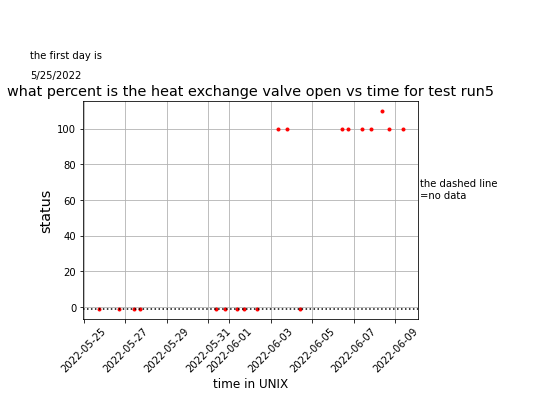

In [16]:
#graphs the parameter with the given info

def graph_parameter_array(parameter, runname):
    #get the units for the y-axis
    yunits = get_parameter_info(parameter)[1]
    
    plt.figure()
    plt.title( parameter + " vs time for " + runname, fontsize = 'x-large')
    plt.xlabel("time in UNIX", fontsize = 'large')
    plt.ylabel(yunits, fontsize='x-large')
    plt.xticks(rotation=45)
    
    #We plot the percentage as linear and the others with values as linear
    #if parameter=="humidity percentage":
        #plt.yscale("linear")
        
    #elif typeoutput =="yes_or_no":
        #plt.yscale("linear")
        
    #else:
        #plt.yscale("log")
        
        
    
    plt.plot(get_unixtime_array(runname),get_parameter_array(parameter,runname), 'r.') 
    

    #plots date labels
    plt.annotate( "the first day is", (30,340), xycoords='figure pixels')
    plt.annotate( get_string_date_array(runname)[0], (30,320), xycoords='figure pixels')
    
    #plot the line for non-data values that were recorded
    type_output = get_parameter_info(parameter)[2]
    
    if type_output == "other" or "heat":
        plt.axhline(-1, linestyle = "dotted", color ="0")
        dashed_line_txt= "the dashed line \n=no data"
        plt.annotate(dashed_line_txt, (420,200), xycoords='figure pixels')  

        
    plt.grid()
        
    #file to save theplots in that is possibly outside of working directoy
    my_path = os.path.abspath(r"C:\Users\sanch\OneDrive\Desktop\JHU REU\crostat_plots\other_plots2")
    my_file = parameter + " "+ runname
    plt.savefig(os.path.join(my_path, my_file),  pad_inches=.1, bbox_inches= "tight", facecolor='w', format = "pdf" )   
    
    plt.show()
    
graph_parameter_array(heat_exchange_valve, test_run5)


#These are your options to graph:
#has typeoutput value_output
#water_supply_temp 
#inlet_temp 
#outlet_temp 
#supply_pressure 
#domestic_water_pressure
#water_return_pressure
#water_flow_rate 
#water_pressure_1A 
#water_pressure_1B 
#humidity_percentage

#this one has typeoutput heat_open
#heat_exchange_valve

#these are other options to graph that are yes/no in possible output

#magnet_on
#water_treatment
#chemical_tank_valves
#water_loop_pumps
#is_1A_running
#is_1B_running
#nitrogen_coldtrap
#O2_sensor
#DR_control

In [17]:
from PyPDF2 import PdfReader, PdfWriter, PdfMerger

#last thing is to make this bigger
merger=PdfWriter()
for filename in os.scandir(r"C:\Users\sanch\OneDrive\Desktop\other_plots2"):
    if filename.is_file():
        total_pdf=[filename.path]
        
        
    for pdf in total_pdf:
        merger.append(pdf)
merger.write("total_other_graphs.pdf")
merger.close()
        
    
        

#### 